# Notebook Description

In this notebook, I attempt to use machine learning to predict whether or not a golfer will make the cut at the Masters Tournament. The models used take inputs consisting of full season aggregate statistics from the previous year to make the predictions for that year's Masters Tournament (e.g., the models used 2018 full season data to predict 2019 results.

Additionally, we will use the subset of golfers that make the cut to attempt to predict the top 10 come Sunday evening at Augusta using the same inputs as before.

# Necessary Packages and Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Webscrapping
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# Sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler as ROS

# Graphing
%matplotlib inline
sns.set_style('darkgrid')
figsize = (15,10)
hspace = 0.5

# Pickling
import pickle
from sklearn.externals import joblib

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Helper Functions

## Webscrapping

In [2]:
# PGATour.com Webscrapping Function
def get_PGA_Tour_data(stats, seasons):

    """
    This function pings the PGA Tour's server and gathers the desired statistics
    (by inserting the stat_id into the url) and appends it to our data container
    """

    data = []
    
    for season in seasons:  
        print(f"Beginning {season} season:")
        for stat in stats: 
            url = f"https://www.pgatour.com/content/pgatour/stats/stat.{stat['stat_id']}.y{season}.html"

            #opening up connection, grabbing the page
            uClient = uReq(url)
            page_html = uClient.read()

            #html parsing using BeautifulSoup
            page_soup = soup(page_html, 'html.parser')

            #find the table where stats are kept
            tbody = page_soup.find('tbody')

            #each golfer is separated by a <tr> tag
            raw_golfers = tbody.findAll('tr')

            #loop through each golfer, grab name and avg. distance
            for raw_golfer in raw_golfers:
                golfer = {}
                golfer['season'] = season            
                name = raw_golfer.find('td', {'class':'player-name'}).a.text
                golfer['full_name'] = name.replace(' ', '_').lower()
                golfer[f"{stat['stat_name']}"] = raw_golfer.find('td', {'class':None}).text
                data.append(golfer)
            print(f" {stat['stat_name']} stats added for the {season} season")
        print(f"{season} season completed.\n")

    #close the client
    uClient.close()

    return data

## Convert Strings to Feet

In [3]:
# Convert stats to feet function
def convert_to_feet(x):
    """
    This function takes in a string and returns a float
    """
    
    if type(x) == str:
        y = x.replace("'","").replace('"',"").split()

        if len(y) == 1:
            y.extend([0])
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

        else:
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

    else:
        return np.nan

## Format Golfer

In [4]:
# Format golfer names from results Dataframe
def format_golfer(x):
    return x.replace(' ','_').lower()

## Plotter Functions

### Confusion Matrix Plotter

In [5]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure(figsize=(5,4));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

### Feature Importance Plotter

In [6]:
# creates feature importance graphs
def plot_feature_importances(X_train, model, n_features, FI_labels):
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), FI_labels) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

# Data Gathering and Cleaning

## Data Gathering

### Desired Features

In [ ]:
# # The stat_id will be inserted into the url for each ping
# stats = [
#     {'stat_name': 'driving_distance',
#      'stat_id': '101'},
#     {'stat_name': 'driving_accuracy', 
#      'stat_id': '102'},
#     {'stat_name': 'greens_in_regulation', 
#      'stat_id': '103'},
#     {'stat_name': 'proximity', 
#      'stat_id': '331'},
#     {'stat_name': 'scrambling_rough',  
#      'stat_id': '363'},
#     {'stat_name': 'scrambling_sand',  
#      'stat_id': '362'},
#     {'stat_name': 'putting_conversion',
#      'stat_id': '115'},
#     {'stat_name': 'putting_rating',
#      'stat_id': '402'},
#     {'stat_name': 'sg_off_tee',
#      'stat_id': '02567'},
#     {'stat_name': 'sg_approach',
#      'stat_id': '02568'},
#     {'stat_name': 'sg_scrambling',  
#      'stat_id': '02569'},
#     {'stat_name': 'sg_putting',
#      'stat_id': '02564'},
#     {'stat_name': 'sg_tee_to_green',  
#      'stat_id': '02674'},
#     {'stat_name': 'sg_total',  
#      'stat_id': '02675'},
#     {'stat_name': 'scoring_avg',  
#      'stat_id': '120'},
# ]

### Seasons Considered

In [ ]:
# # Since strokes_gained stats only go back to 2004, we will consider 2004-2019
# seasons = range(2004, 2020)

### Webscrapping and Dataframe Conversion

In [ ]:
# # Call the web scrapping helper function defined above. Save the results and examine Dataframe
# data = get_PGA_Tour_data(stats, seasons)

In [ ]:
# # Convert data to Dataframe and save raw data locally
# df = pd.DataFrame(data)
# df.to_csv('csv_files/raw_golfer_data.csv')

## Data Cleaning

### Convert Features

In [320]:
# Reload raw data and examine dataframe
df = pd.read_csv('csv_files/raw_golfer_data.csv', index_col=0)
df.drop('str_diff_to_field', axis=1, inplace=True)
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(48592, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,hank_kuehne,314.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,scott_hend,312.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004,john_daly,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,mike_heinen,305.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,chris_smith,304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [321]:
# Convert proximity to feet floats and str_diff_to_field to stroke floats
df['proximity'] = df['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
df['driving_accuracy'] = df['driving_accuracy']/100
df['greens_in_regulation'] = df['greens_in_regulation']/100
df['scrambling_rough'] = df['scrambling_rough']/100
df['scrambling_sand'] = df['scrambling_sand']/100
df['putting_conversion'] = df['putting_conversion']/100

### Groupby Season and Golfer

In [322]:
# Group stats by season and golfer
df = df.groupby(['season', 'full_name'])[
    'driving_distance',
    'driving_accuracy',
    'greens_in_regulation',
    'proximity',
    'scrambling_rough',
    'scrambling_sand',
    'putting_conversion',
    'putting_rating',
    'sg_off_tee',
    'sg_approach',
    'sg_scrambling',
    'sg_putting',
    'sg_tee_to_green',
    'sg_total',
    'scoring_avg'
].mean()

# Save grouped data locally
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine data
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(3036, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Add Missing Golfers

In [323]:
# Import new csv file that contains data on missing golfers
missing = pd.read_csv('csv_files/masters_results - missing.csv')

print(missing.shape)
missing.head()

(29, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,trevor_immelman,282.3,63.89,60.34,"36' 5""",50.85,48.48,25.45,1.633,0.057,0.282,-0.031,-1.020,0.308,0.207,71.224
1,2005,ángel_cabrera,311.2,53.30,63.33,"37' 10""",54.29,47.50,29.03,1.665,0.531,0.067,0.141,-0.136,0.739,0.603,70.669
2,2006,paul_casey,305.3,62.66,67.17,"32' 1""",45.00,53.57,26.42,1.707,0.118,1.385,-0.249,-0.641,1.254,0.613,70.837
3,2007,andres_romero,312.5,56.25,58.89,"33' 10""",76.47,62.16,26.42,1.572,1.988,-0.457,0.342,0.416,1.873,2.289,68.653
4,2007,robert_karlsson,298.9,51.02,57.54,"36' 2""",51.55,44.44,27.36,1.631,-0.130,-0.219,-0.025,-0.374,-0.022,-0.396,71.396


In [324]:
# Convert the features of missing golfers
missing['proximity'] = missing['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
missing['driving_accuracy'] = missing['driving_accuracy']/100
missing['greens_in_regulation'] = missing['greens_in_regulation']/100
missing['scrambling_rough'] = missing['scrambling_rough']/100
missing['scrambling_sand'] = missing['scrambling_sand']/100
missing['putting_conversion'] = missing['putting_conversion']/100

In [325]:
concat = [df, missing]
df = pd.concat(concat)

In [326]:
df.sort_values(by=['season', 'full_name'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(3065, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Incorporate Historical Tournament Data

In [327]:
# Load Masters Results data and format each golfer to match our data's format
masters_results = pd.read_csv('csv_files/masters_results - data.csv')
masters_results['full_name'] = masters_results['full_name'].apply(lambda x: format_golfer(x))
masters_results = masters_results.sort_values(by=['masters_year', 'full_name'])

print(masters_results.shape)
masters_results.head()

(1469, 6)


,masters_year,full_name,total_score,made_cut,top_10,champion
32,2005,adam_scott,294,1,0,0
51,2005,austin_eaton_iii,315,0,0,0
52,2005,ben_crenshaw,315,0,0,0
53,2005,ben_curtis,315,0,0,0
19,2005,bernhard_langer,289,1,0,0


In [328]:
# Merge dataframes together on name
df = pd.merge(df, masters_results, how='left', on='full_name')

# Drop Nans
df.dropna(inplace=True)

# Only consider rows where golfer participated the following masters
df = df[df['masters_year']-df['season'] == 1]

# Drop Masters year and reset Index
df.drop('masters_year', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Change made_cut and top_10 to integers
df['made_cut'] = df['made_cut'].astype(int)
df['top_10'] = df['top_10'].astype(int)
df['champion'] = df['champion'].astype(int)
df['total_score'] = df['total_score'].astype(int)

# Reorder columns and examine new dataframe
cols = ['season', 'full_name', 'champion', 'top_10', 'made_cut', 'total_score',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'proximity',
        'scrambling_rough', 'scrambling_sand', 'putting_conversion', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
        'sg_total', 'scoring_avg']

df = df[cols]

print(df.shape)
df.head()

(953, 21)


,season,full_name,champion,top_10,made_cut,total_score,driving_distance,driving_accuracy,greens_in_regulation,proximity,...,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,adam_scott,0,0,1,294,295.4,0.5765,0.6560,35.333333,...,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
1,2004,ben_curtis,0,0,0,315,282.1,0.6434,0.6335,37.333333,...,0.4583,0.2513,1.620,0.171,0.274,0.223,-0.174,0.669,0.494,71.578
2,2004,bernhard_langer,0,0,1,289,282.2,0.6257,0.6525,34.416667,...,0.4483,0.2768,1.608,0.029,0.616,0.055,-0.229,0.700,0.471,71.246
3,2004,bo_van_pelt,0,0,0,315,294.4,0.6515,0.6768,36.333333,...,0.4369,0.3136,1.623,0.512,0.194,0.094,0.346,0.800,1.146,70.245
4,2004,carlos_franco,0,0,0,315,290.6,0.5933,0.6846,36.083333,...,0.5843,0.2838,1.637,0.130,0.413,0.236,-0.134,0.779,0.645,70.768


# Holdout Set

In [329]:
# Create holdout set of 2019 data. Holdout set will be used for predicting 2020 Masters results
holdout = df[df['season'] == 2019]
df = df[df['season'] != 2019]

# Examine holdout and dataframe
print(f"Holdout Set: {holdout.shape}")
print(f"Validation Set: {df.shape}")

# Overwrite grouped data and save both the holdout set and grouped dataframe locally
holdout.to_csv('csv_files/holdout_data.csv')
df.to_csv('csv_files/no_2019_golfer_data.csv')

Holdout Set: (58, 21)
Validation Set: (895, 21)


# Feature Engineering

In [330]:
df = pd.read_csv('csv_files/no_2019_golfer_data.csv', index_col=0)

print(df.shape)
df.head()

(895, 21)


,season,full_name,champion,top_10,made_cut,total_score,driving_distance,driving_accuracy,greens_in_regulation,proximity,...,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,adam_scott,0,0,1,294,295.4,0.5765,0.6560,35.333333,...,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
1,2004,ben_curtis,0,0,0,315,282.1,0.6434,0.6335,37.333333,...,0.4583,0.2513,1.620,0.171,0.274,0.223,-0.174,0.669,0.494,71.578
2,2004,bernhard_langer,0,0,1,289,282.2,0.6257,0.6525,34.416667,...,0.4483,0.2768,1.608,0.029,0.616,0.055,-0.229,0.700,0.471,71.246
3,2004,bo_van_pelt,0,0,0,315,294.4,0.6515,0.6768,36.333333,...,0.4369,0.3136,1.623,0.512,0.194,0.094,0.346,0.800,1.146,70.245
4,2004,carlos_franco,0,0,0,315,290.6,0.5933,0.6846,36.083333,...,0.5843,0.2838,1.637,0.130,0.413,0.236,-0.134,0.779,0.645,70.768


## Birdie or Better Distance
Generate a circle where the radius equals a golfer's maximum distance from the hole in which the golfer will make a birdie or better from

In [331]:
df['on_the_green_area'] = df['proximity']**2 * np.pi
df['birdie_or_better_area'] = df['on_the_green_area']*df['putting_conversion']
df['birdie_or_better_distance'] = np.sqrt(df['birdie_or_better_area']/np.pi)
df['birdie_or_worse_distance'] = df['proximity']-df['birdie_or_better_distance']
df.drop(['proximity', 'putting_conversion', 'on_the_green_area', 'birdie_or_better_area'], axis=1, inplace=True)

## Prior Tournament Score & Rolling Average

In [332]:
# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut', 'total_score',
       'driving_distance', 'driving_accuracy', 'greens_in_regulation',
       'scrambling_rough', 'scrambling_sand', 'putting_rating', 'sg_off_tee',
       'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
       'sg_total', 'scoring_avg', 'birdie_or_better_distance',
       'birdie_or_worse_distance'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(895, 21)


,full_name,season,champion,top_10,made_cut,total_score,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,...,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
0,aaron_baddeley,2006,0,0,1,307,288.3,0.6073,0.5826,0.6100,...,1.553,-0.106,-0.607,0.196,0.595,-0.517,0.078,71.197,21.326667,16.756667
1,aaron_baddeley,2007,0,0,0,315,291.9,0.6000,0.6035,0.6021,...,1.570,0.152,-0.252,0.535,0.629,0.435,1.064,70.088,21.005830,16.244170
2,aaron_baddeley,2008,0,0,1,284,290.3,0.5945,0.6202,0.5549,...,1.577,0.096,-0.192,0.218,0.762,0.123,0.885,70.196,21.109307,17.057360
3,aaron_baddeley,2010,0,0,1,293,298.9,0.5665,0.6460,0.5458,...,1.587,0.112,-0.797,0.391,0.502,-0.294,0.208,70.995,21.237521,16.512479
4,aaron_baddeley,2011,0,0,1,293,296.2,0.5567,0.6548,0.4932,...,1.536,0.190,0.196,0.438,0.324,0.824,1.148,70.230,21.490982,15.925685


In [333]:
# Generate a list of unique golfers and nan values to poulate 2019
golfers = df['full_name'].unique().tolist()

# Create a list of dictionaries to house each golfers score at the Masters for every tournament he played in
names_and_scores = []
for golfer in golfers:
    name_and_scores = {}
    name_and_scores['golfer'] = golfer
    scores = []
    for i in range(df.shape[0]):
        if golfer == df['full_name'].iloc[i]:
            scores.append(df['total_score'].iloc[i])
        else:
            continue
    name_and_scores['scores'] = scores
    names_and_scores.append(name_and_scores)

# Loop through list of dictionaries and create a lagged score list for each golfer
for golfer in names_and_scores:
    scores_lagged = []
    rolling_avgs = []
    experiences = []
    for i in range(len(golfer['scores'])):  
        experience = i+1
        experiences.append(experience)
        score_lagged = golfer['scores'][i-1]
        scores_lagged.append(score_lagged)
        scores_lagged[0] = 315
        rolling_avg = np.mean(scores_lagged)
        rolling_avgs.append(rolling_avg)
    golfer['experience'] = experiences
    golfer['scores_lagged'] = scores_lagged
    golfer['rolling_avg'] = rolling_avgs

# Join all of the sepearate lists together
lagged_scores = []
rolling_averages = []
experiences = []
for golfer in names_and_scores:
    lagged_scores.extend(golfer['scores_lagged'])
    rolling_averages.extend(golfer['rolling_avg'])
    experiences.extend(golfer['experience'])

# Add to our dataframe
df['experience'] = experiences
df['rolling_avg'] = rolling_averages
df['prior_score'] = lagged_scores

## Masters Experience
Create another column that quantifies how many times a golfer has played at the Masters at that point in time

In [334]:
# # Create new count dataframe to add the number of times a golfer has played in Masters
# count = pd.DataFrame(df[df['season']!=2019].full_name.value_counts())
# count.reset_index(drop=False, inplace=True)
# count['new_full_name'] = count['index']
# count['experience'] = count['full_name']
# count = count[['new_full_name', 'experience']]
# count['full_name'] = count['new_full_name']
# count.drop('new_full_name', axis=1, inplace=True)
# count = count[['full_name', 'experience']]

# # Merge existing dataframe and new count dataframe
# df = pd.merge(df, count, how='inner', on='full_name')

## Field Average Score
Create a column that is the average score of the field that year for each golfer

In [335]:
# Get each year's Masters Tournament average score for the field
hist_scores = pd.DataFrame(df.groupby('season')['prior_score'].agg('mean'))
hist_scores.reset_index(drop=False, inplace=True)
hist_scores['prior_avg_field_score'] = hist_scores['prior_score'].astype(int)
hist_scores.drop('prior_score', axis=1, inplace=True)

# Merge with our dataframe
df = pd.merge(df, hist_scores, how='inner', on='season')

In [336]:
df.head()

,full_name,season,champion,top_10,made_cut,total_score,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,...,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance,experience,rolling_avg,prior_score,prior_avg_field_score
0,aaron_baddeley,2006,0,0,1,307,288.3,0.6073,0.5826,0.6100,...,0.595,-0.517,0.078,71.197,21.326667,16.756667,1,315.000000,315,301
1,adam_scott,2006,0,0,1,300,301.1,0.6200,0.6912,0.4602,...,-0.130,2.230,2.101,68.946,18.605405,15.144595,3,300.333333,292,301
2,arron_oberholser,2006,0,0,1,310,285.0,0.6253,0.6927,0.6154,...,0.167,0.927,1.095,69.858,18.822897,16.010437,2,301.500000,288,301
3,bart_bryant,2006,0,0,0,315,282.2,0.7276,0.6867,0.5592,...,-0.138,0.533,0.395,70.745,16.733242,16.766758,2,315.000000,315,301
4,ben_crane,2006,0,0,0,315,285.8,0.6351,0.6201,0.5179,...,0.849,-0.369,0.480,70.834,21.400502,16.266165,2,315.000000,315,301


## Strokes Gained Over Field
Create a new column that calculates how much better (or worse) the golfer did than the field average that year

In [337]:
# Create column
df['sg_over_field'] = df['prior_avg_field_score']-df['prior_score']


#Rearrange columns and examine dataframe
cols = ['season', 'full_name', 'experience', 'champion', 'top_10', 'made_cut', 'sg_over_field',
        'total_score', 'prior_score', 'rolling_avg', 'prior_avg_field_score', 'driving_distance', 'driving_accuracy',
        'greens_in_regulation', 'scrambling_rough', 'scrambling_sand', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',   
        'sg_total', 'scoring_avg', 'birdie_or_better_distance', 'birdie_or_worse_distance']

df = df[cols]

print(df.shape)
df.head()

(895, 26)


,season,full_name,experience,champion,top_10,made_cut,sg_over_field,total_score,prior_score,rolling_avg,...,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
0,2006,aaron_baddeley,1,0,0,1,-14,307,315,315.000000,...,1.553,-0.106,-0.607,0.196,0.595,-0.517,0.078,71.197,21.326667,16.756667
1,2006,adam_scott,3,0,0,1,9,300,292,300.333333,...,1.627,0.955,1.115,0.160,-0.130,2.230,2.101,68.946,18.605405,15.144595
2,2006,arron_oberholser,2,0,0,1,13,310,288,301.500000,...,1.642,0.095,0.589,0.243,0.167,0.927,1.095,69.858,18.822897,16.010437
3,2006,bart_bryant,2,0,0,0,-14,315,315,315.000000,...,1.670,0.299,0.379,-0.145,-0.138,0.533,0.395,70.745,16.733242,16.766758
4,2006,ben_crane,2,0,0,0,-14,315,315,315.000000,...,1.581,-0.233,-0.408,0.272,0.849,-0.369,0.480,70.834,21.400502,16.266165


## Save Data

In [338]:
df.sort_values(by=['season', 'full_name'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv('csv_files/no_2019_golfer_data.csv')

# Exploratory Data Analysis

## General Information

In [339]:
df = pd.read_csv('csv_files/no_2019_golfer_data.csv', index_col=0)

print(df.shape)
df.head(10)

(895, 26)


,season,full_name,experience,champion,top_10,made_cut,sg_over_field,total_score,prior_score,rolling_avg,...,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
0,2004,adam_scott,1,0,0,1,0,294,315,315.0,...,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096,20.266678,15.066656
1,2004,ben_curtis,1,0,0,0,0,315,315,315.0,...,1.620,0.171,0.274,0.223,-0.174,0.669,0.494,71.578,18.715137,18.618196
2,2004,bernhard_langer,1,0,0,1,0,289,315,315.0,...,1.608,0.029,0.616,0.055,-0.229,0.700,0.471,71.246,18.107223,16.309444
3,2004,bo_van_pelt,1,0,0,0,0,315,315,315.0,...,1.623,0.512,0.194,0.094,0.346,0.800,1.146,70.245,20.346667,15.986667
4,2004,carlos_franco,1,0,0,0,0,315,315,315.0,...,1.637,0.130,0.413,0.236,-0.134,0.779,0.645,70.768,19.222632,16.860702
5,2004,chad_campbell,1,0,0,1,0,288,315,315.0,...,1.642,0.183,0.660,-0.132,-0.186,0.711,0.525,70.808,17.471832,16.694834
6,2004,charles_howell_iii,1,0,0,0,0,315,315,315.0,...,1.633,0.428,0.018,0.095,0.002,0.541,0.543,70.773,19.337576,18.079090
7,2004,chris_dimarco,1,0,1,1,0,276,315,315.0,...,1.600,0.134,0.508,0.299,0.121,0.942,1.063,70.276,19.294503,16.205497
8,2004,chris_riley,1,0,0,1,0,304,315,315.0,...,1.582,-0.235,0.192,0.297,0.122,0.255,0.377,70.844,19.115615,17.217718
9,2004,craig_parry,1,0,0,1,0,290,315,315.0,...,1.609,-0.133,-0.037,0.345,0.113,0.175,0.288,71.414,19.105769,18.227565


In [340]:
top10 = df[df['top_10'] == 1]

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 894
Data columns (total 26 columns):
season                       895 non-null int64
full_name                    895 non-null object
experience                   895 non-null int64
champion                     895 non-null int64
top_10                       895 non-null int64
made_cut                     895 non-null int64
sg_over_field                895 non-null int64
total_score                  895 non-null int64
prior_score                  895 non-null int64
rolling_avg                  895 non-null float64
prior_avg_field_score        895 non-null int64
driving_distance             895 non-null float64
driving_accuracy             895 non-null float64
greens_in_regulation         895 non-null float64
scrambling_rough             895 non-null float64
scrambling_sand              895 non-null float64
putting_rating               895 non-null float64
sg_off_tee                   895 non-null float64
sg_approach   

In [342]:
top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 7 to 893
Data columns (total 26 columns):
season                       159 non-null int64
full_name                    159 non-null object
experience                   159 non-null int64
champion                     159 non-null int64
top_10                       159 non-null int64
made_cut                     159 non-null int64
sg_over_field                159 non-null int64
total_score                  159 non-null int64
prior_score                  159 non-null int64
rolling_avg                  159 non-null float64
prior_avg_field_score        159 non-null int64
driving_distance             159 non-null float64
driving_accuracy             159 non-null float64
greens_in_regulation         159 non-null float64
scrambling_rough             159 non-null float64
scrambling_sand              159 non-null float64
putting_rating               159 non-null float64
sg_off_tee                   159 non-null float64
sg_approach   

In [343]:
df.drop(['season', 'total_score', 'made_cut', 'top_10', 'champion'],axis=1).describe()

,experience,sg_over_field,prior_score,rolling_avg,prior_avg_field_score,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,3.778771,-0.488268,301.013408,304.892282,300.525140,292.145251,0.620209,0.659189,0.571287,0.532882,1.609478,0.206085,0.291841,0.094941,0.109992,0.592802,0.706368,70.377980,19.249806,16.047959
std,2.932918,13.116908,13.956141,8.745650,4.853697,8.971336,0.049987,0.027971,0.051435,0.073888,0.034899,0.356128,0.372284,0.222722,0.343016,0.604835,0.642931,0.653111,1.128083,1.025834
min,1.000000,-21.000000,270.000000,285.500000,294.000000,268.500000,0.483100,0.543300,0.434800,0.250000,1.430000,-2.158000,-2.155000,-0.930000,-1.216000,-3.923000,-2.385000,67.646000,15.612389,12.785571
25%,1.000000,-14.000000,288.000000,297.666667,298.000000,285.700000,0.585300,0.642200,0.538500,0.484200,1.591000,-0.005500,0.079500,-0.046500,-0.119000,0.269000,0.334000,70.018500,18.500484,15.373800
50%,3.000000,1.000000,299.000000,304.000000,300.000000,292.000000,0.619700,0.660800,0.571400,0.538500,1.611000,0.213000,0.300000,0.095000,0.116000,0.596000,0.711000,70.368000,19.227367,15.997974
75%,5.000000,11.000000,315.000000,315.000000,303.000000,298.100000,0.649800,0.678350,0.603900,0.582400,1.633000,0.431000,0.512500,0.248000,0.338500,0.929500,1.069000,70.767500,19.954849,16.664254
max,15.000000,27.000000,315.000000,315.000000,315.000000,319.700000,0.784300,0.741500,0.786900,0.753200,1.716000,1.988000,2.072000,0.757000,1.931000,2.982000,3.815000,73.290000,22.704801,22.166667


In [344]:
top10.drop(['season', 'total_score', 'made_cut', 'top_10', 'champion'],axis=1).describe()

,experience,sg_over_field,prior_score,rolling_avg,prior_avg_field_score,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,4.075472,2.679245,297.566038,302.048490,300.245283,295.696855,0.608222,0.665431,0.576537,0.546057,1.609327,0.317811,0.441371,0.145327,0.123591,0.917006,1.049774,70.031314,19.436097,15.637802
std,2.882833,13.649000,14.535652,9.301884,4.838816,9.241681,0.043915,0.030560,0.056751,0.077657,0.033285,0.382935,0.426832,0.210813,0.392486,0.625655,0.715918,0.703343,1.144267,1.047326
min,1.000000,-21.000000,270.000000,286.000000,294.000000,277.000000,0.510200,0.550000,0.438800,0.337800,1.488000,-0.506000,-1.311000,-0.437000,-1.216000,-0.715000,-0.968000,67.646000,16.490958,12.785571
25%,2.000000,-14.000000,286.000000,294.187500,298.000000,289.350000,0.575250,0.649750,0.541100,0.492250,1.588500,0.054500,0.224000,-0.008000,-0.141000,0.497500,0.639500,69.573000,18.612870,14.955757
50%,3.000000,8.000000,292.000000,300.000000,300.000000,295.400000,0.605000,0.668900,0.577500,0.551700,1.610000,0.304000,0.474000,0.170000,0.128000,0.882000,0.985000,70.101000,19.479940,15.627559
75%,6.000000,13.000000,315.000000,315.000000,301.000000,301.050000,0.641050,0.687100,0.608700,0.589600,1.631500,0.540500,0.617000,0.273000,0.368500,1.269500,1.385500,70.493500,20.277329,16.280884
max,13.000000,27.000000,315.000000,315.000000,315.000000,317.700000,0.719000,0.741500,0.785700,0.724100,1.707000,1.988000,2.072000,0.757000,1.931000,2.982000,3.815000,71.581000,22.704801,18.045189


## Target Variable Summaries

### Cut Line

In [345]:
# Define the cutlines
cut_lines = pd.read_csv('csv_files/masters_results - cutline.csv')

print(cut_lines.shape)
cut_lines.head()

(15, 3)


,season,total_score,relative_to_par
0,2005,149,5
1,2006,149,5
2,2007,153,9
3,2008,148,4
4,2009,146,2


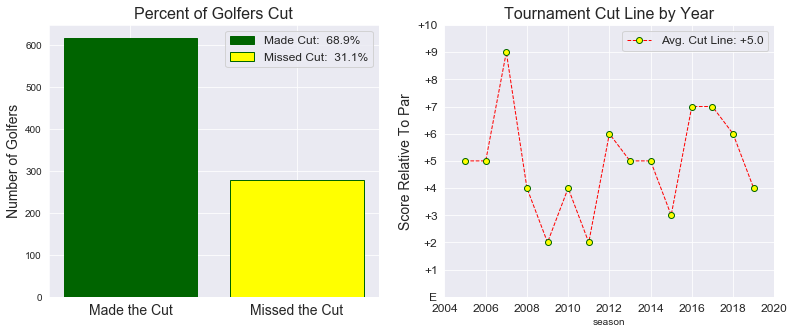

In [346]:
target_variable = 'made_cut'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Cut
height = df.groupby(target_variable).season.count().tolist()
missed_cut = height[0]
made_cut = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=made_cut,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Made Cut: {made_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Missed Cut: {missed_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.set_title("Percent of Golfers Cut", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Made the Cut', 'Missed the Cut'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper right', fontsize='large');

# Cutline overtime
avg_cutline = round(cut_lines['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

cut_lines.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Cut Line: +{avg_cutline}'
);
ax2.set_title("Tournament Cut Line by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.set_yticks(range(0, 11));
ax2.set_yticklabels(
    ('E', '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8', '+9', '+10')
);
ax2.set_xlim(2004, 2020);
ax2.legend(loc='upper right', fontsize='large');

In [426]:
made_cut[made_cut['full_name'] =='matt_kuchar']

,season,full_name,experience,champion,top_10,made_cut,sg_over_field,total_score,prior_score,rolling_avg,...,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
335,2009,matt_kuchar,1,0,0,1,-16,288,315,315.000000,...,1.575,0.120,0.052,0.289,0.698,0.461,1.158,70.112,19.166861,14.999806
396,2010,matt_kuchar,2,0,0,1,10,287,288,301.500000,...,1.596,0.158,0.336,0.334,0.633,0.827,1.461,69.606,19.416514,15.333486
460,2011,matt_kuchar,3,0,1,1,11,280,287,296.666667,...,1.585,0.304,0.698,0.158,0.379,1.161,1.540,69.515,19.191185,14.808815
516,2012,matt_kuchar,4,0,1,1,16,285,280,292.500000,...,1.584,0.110,0.490,0.309,0.472,0.910,1.382,69.477,18.611968,15.638032
581,2013,matt_kuchar,5,0,1,1,15,286,285,291.000000,...,1.591,-0.010,0.731,0.278,0.398,0.999,1.398,69.561,18.823230,15.176770
649,2014,matt_kuchar,6,0,0,1,15,290,286,290.166667,...,1.597,0.210,0.527,0.380,0.457,1.117,1.573,69.416,19.397625,15.685708
708,2015,matt_kuchar,7,0,0,1,5,294,290,290.142857,...,1.577,0.136,0.202,0.479,0.316,0.817,1.133,70.040,20.853804,15.896196
762,2016,matt_kuchar,8,0,1,1,9,283,294,290.625000,...,1.612,0.364,0.326,0.242,0.381,0.933,1.314,69.844,19.528425,15.304908
816,2017,matt_kuchar,9,0,0,1,15,288,283,289.777778,...,1.595,0.158,0.253,0.430,0.332,0.840,1.173,69.806,19.135763,16.447571
874,2018,matt_kuchar,10,0,0,1,6,280,288,289.600000,...,1.603,-0.199,0.216,0.211,0.348,0.228,0.576,70.461,19.061093,16.188907


### Top 10

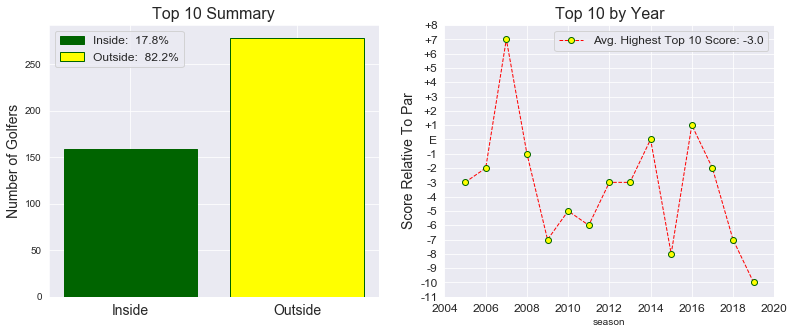

In [347]:
target_variable = 'top_10'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Inside Top 10
height = df.groupby(target_variable).season.count().tolist()
outside_top10 = height[0]
inside_top10 = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=inside_top10,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Inside: {inside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Outside: {outside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.set_title("Top 10 Summary", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Inside', 'Outside'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper left', fontsize='large');

# Top 10 overtime
top_10 = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
top_10.reset_index(drop=False, inplace=True)
top_10['season'] = top_10['season']+1
top_10['relative_to_par'] = top_10['total_score']-(72*4)
avg_top10 = round(top_10['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

top_10.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Highest Top 10 Score: {avg_top10}'
);
ax2.set_title("Top 10 by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
ax2.set_yticks(range(-11, 9));
ax2.set_yticklabels(
    ('-11', '-10', '-9', '-8',
     '-7', '-6', '-5', '-4',
     '-3', '-2', '-1', 'E',
     '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8')
);
ax2.set_xlim(2004, 2020);

In [414]:
top10 = df[df['top_10'] == 1]
top10 = pd.DataFrame(top10['full_name'].value_counts())
top10.iloc[:10]

,full_name
tiger_woods,9
phil_mickelson,7
rory_mcilroy,5
justin_rose,5
lee_westwood,5
paul_casey,4
ángel_cabrera,4
matt_kuchar,4
jordan_spieth,4
dustin_johnson,4


### Past Champions and Worst Performers

In [348]:
# Create a new dataframe that grabs golfers, their total experience, and number/pct of times they made the cut
experience = pd.DataFrame(df.groupby('full_name').driving_distance.count())
experience.reset_index(drop=False, inplace=True)

cut_summary = pd.DataFrame(df.groupby('full_name').made_cut.sum())
cut_summary.reset_index(drop=False, inplace=True)

cut_summary = pd.merge(experience, cut_summary, how='outer', on='full_name')
cut_summary['experience'] = cut_summary['driving_distance']
cut_summary = cut_summary[['full_name', 'experience', 'made_cut']]
cut_summary['cuts_missed'] = cut_summary['experience'] - cut_summary['made_cut']
cut_summary['cuts_missed_pct'] = cut_summary['cuts_missed']/cut_summary['experience']*100
cut_summary = cut_summary[cut_summary['experience'] >= 4]

# Grab golfers that have missed more than 50% of cuts
augusta_hates = cut_summary[cut_summary['cuts_missed_pct'] >= 50]
raw_golfers = augusta_hates['full_name'].tolist()
golfers = [golfer.replace('_', ' ').title() for golfer in raw_golfers]
augusta_hates['Golfers'] = golfers
augusta_hates.set_index('Golfers', inplace=True)
augusta_hates.sort_values(by='cuts_missed_pct', ascending=False, inplace=True)
augusta_hates

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,full_name,experience,made_cut,cuts_missed,cuts_missed_pct
Golfers,,,,,
Shaun Micheel,shaun_micheel,4,0,4,100.000000
Ben Curtis,ben_curtis,7,2,5,71.428571
Ben Crane,ben_crane,6,2,4,66.666667
Gary Woodland,gary_woodland,6,2,4,66.666667
Rory Sabbatini,rory_sabbatini,8,3,5,62.500000
Camilo Villegas,camilo_villegas,6,3,3,50.000000
Charles Howell Iii,charles_howell_iii,6,3,3,50.000000
Graeme Mcdowell,graeme_mcdowell,4,2,2,50.000000
John Senden,john_senden,6,3,3,50.000000


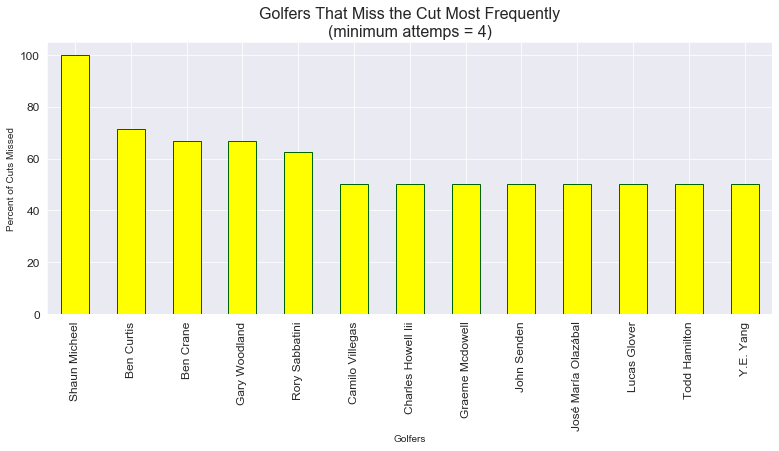

In [349]:
fig = plt.figure(figsize=(13,5));
ax = fig.add_subplot(111);
augusta_hates['cuts_missed_pct'].plot.bar(
    ax=ax,
    ec='darkgreen',
    fc='yellow',
    fontsize=12
);
ax.set_title(
    'Golfers That Miss the Cut Most Frequently\n(minimum attemps = 4)', 
    {'fontsize' : 16}
);
ax.set_ylabel('Percent of Cuts Missed');

In [350]:
df[(df['champion']==1) |
   (df['top_10']==1) |
   (df['made_cut']==1)
  ].groupby(['full_name'])[
    'champion', 'top_10', 'made_cut'
].sum().sort_values(by='made_cut',ascending=False).iloc[0:6]

,champion,top_10,made_cut
full_name,,,
adam_scott,1,4,14
phil_mickelson,2,7,13
tiger_woods,2,9,12
ian_poulter,0,3,11
matt_kuchar,0,4,10
bubba_watson,2,3,10


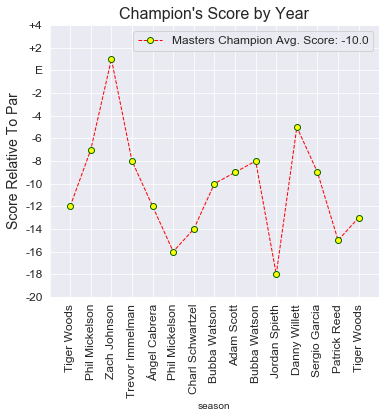

In [351]:
target_variable = 'champion'
title = 'Masters Champion'
fig = plt.figure(figsize=(13,5));

#Champion's score overtime
champion = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
champion.reset_index(drop=False, inplace=True)
champion['season'] = champion['season']+1
champion['relative_to_par'] = champion['total_score']-(72*4)
avg_champion = round(champion['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

champion.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Masters Champion Avg. Score: {avg_champion}'
);
ax2.set_title("Champion's Score by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
raw_champions = df[df['champion'] == 1].full_name.tolist()
champions = [champion.replace('_', ' ').title() for champion in raw_champions]
ax2.set_xticks(range(2005, 2020));
ax2.set_xticklabels(champions, rotation=90);
ax2.set_yticks(range(-20, 6, 2));
ax2.set_yticklabels(
    ('-20', '-18', '-16', '-14',
     '-12', '-10', '-8', '-6',
     '-4', '-2', 'E', '+2', '+4')
);
ax2.set_xlim(2004, 2020);

## Visualizations by Feature

### Feature Correlations

In [352]:
df.columns

Index(['season', 'full_name', 'experience', 'champion', 'top_10', 'made_cut',
       'sg_over_field', 'total_score', 'prior_score', 'rolling_avg',
       'prior_avg_field_score', 'driving_distance', 'driving_accuracy',
       'greens_in_regulation', 'scrambling_rough', 'scrambling_sand',
       'putting_rating', 'sg_off_tee', 'sg_approach', 'sg_scrambling',
       'sg_putting', 'sg_tee_to_green', 'sg_total', 'scoring_avg',
       'birdie_or_better_distance', 'birdie_or_worse_distance'],
      dtype='object')

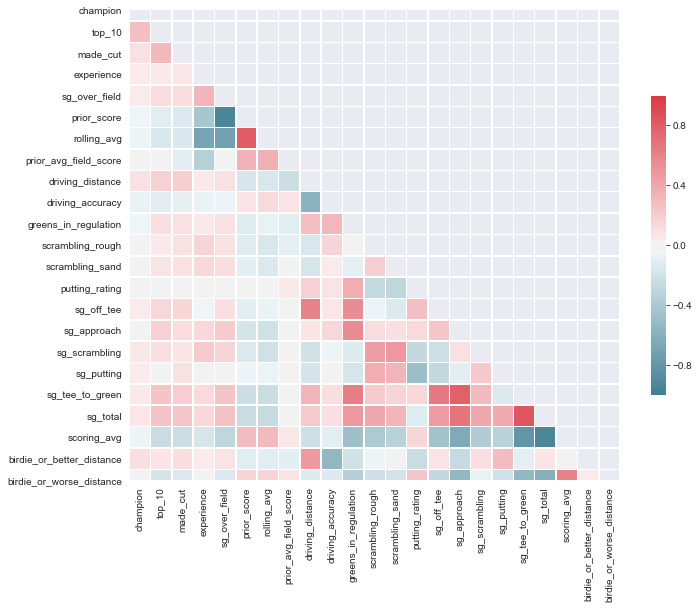

In [353]:
df_corr = df.drop(['season', 'full_name', 'total_score'], axis=1)

cols = ['champion', 'top_10', 'made_cut', 'experience', 'sg_over_field', 'prior_score',
        'rolling_avg', 'prior_avg_field_score', 'driving_distance', 'driving_accuracy',
        'greens_in_regulation', 'scrambling_rough', 'scrambling_sand', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',   
        'sg_total', 'scoring_avg', 'birdie_or_better_distance', 'birdie_or_worse_distance']

df_corr = df_corr[cols]

fig = plt.figure(figsize=(11,11))

# Create mask
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = fig.add_subplot(111)
sns.heatmap(df_corr.corr(),
            mask=mask, 
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            ax=ax1);

### Strokes Gained Over Field

In [409]:
dataset = df[['season', 'full_name', 'total_score']]

experience = pd.DataFrame(df.groupby('full_name').driving_distance.count())
experience.reset_index(drop=False, inplace=True)
experience['experience'] = experience['driving_distance']
experience.drop('driving_distance', axis=1, inplace=True)

dataset = pd.merge(dataset, experience, how='outer', on='full_name')

field_avg = pd.DataFrame(df.groupby('season').total_score.mean())
field_avg.reset_index(drop=False, inplace=True)
field_avg['field_avg'] = field_avg['total_score']
field_avg.drop('total_score', axis=1, inplace=True)
field_avg

dataset = pd.merge(dataset, field_avg, how='outer', on='season')
dataset = dataset[['season', 'full_name', 'experience', 'total_score', 'field_avg']]
dataset['sg_on_field'] = dataset['field_avg']- dataset['total_score']

print(dataset[(dataset['experience'] < 4)].sg_on_field.mean())
print(dataset[(dataset['experience'] > 3)&(dataset['experience'] < 11)].sg_on_field.mean())
print(dataset[(dataset['experience'] > 11)].sg_on_field.mean())

-4.04727801104873
1.2065976812344836
4.15250815919411


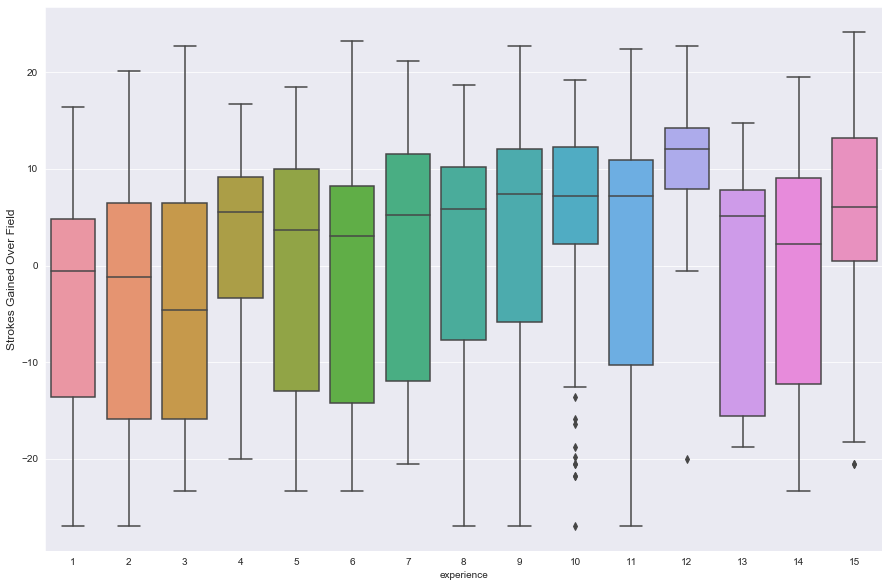

In [399]:
fig = plt.figure(figsize=figsize);
ax = fig.add_subplot(111);

sns.boxplot(
    x=dataset['experience'],
    y=dataset['sg_on_field']
);
ax.set_ylabel('Strokes Gained Over Field', fontsize=12);

### Prior Score

In [ ]:
# Only consider times after 2002 since no one has data prior
df_no_2002 = df[df['season'] != 2002]

# Define sub-dataframes for visualizations
made_cut = df_no_2002[df_no_2002['made_cut'] == 1]
missed_cut = df_no_2002[df_no_2002['made_cut'] == 0]
inside_top10 = df_no_2002[df_no_2002['top_10'] == 1]
outside_top10 = df_no_2002[df_no_2002['top_10'] == 0]

In [ ]:
# Define universal Variables
feature = 'prior_score'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 265
xmax = 320
ymin = 285
ymax = 320
missed_cut_min = df_no_2002[df_no_2002['made_cut']==0][feature].min()
out_t10_min = df_no_2002[df_no_2002['top_10']==0][feature].min()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto',
    color='blue',
    ax=ax1
);
sns.distplot(
    missed_cut[feature],
    bins='auto',
    color='red',
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend();

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df_no_2002[feature],
    y=df_no_2002['made_cut'],
    hue=df_no_2002['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(missed_cut_min, linestyle = '--', color ='red', label=f'Missed Cut Min: {missed_cut_min}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend();

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend();

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df_no_2002[feature],
    y=df_no_2002['top_10'],
    hue=df_no_2002['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(out_t10_min, linestyle = '--', color ='red', label=f'Outside Top 10 Min: {out_t10_min}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.' 
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend();

### Driving Distance

In [ ]:
#Re-define sub-dataframes for correct time period
made_cut = df[df['made_cut'] == 1]
missed_cut = df[df['made_cut'] == 0]
inside_top10 = df[df['top_10'] == 1]
outside_top10 = df[df['top_10'] == 0]

In [ ]:
# Define universal Variables
feature = 'driving_distance'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 260
xmax = 330
ymin = 270
ymax = 310
made_cut_min = df[df['made_cut']==1][feature].min()
missed_cut_max = df[df['made_cut']==0][feature].max()
in_t10_min = df[df['top_10']==1][feature].min()
out_t10_max = df[df['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

### Driving Accuracy

In [ ]:
feature = 'driving_accuracy'
mean1_made = made_cut[feature].mean()
mean1_missed = missed_cut[feature].mean()
mean2_in = inside_top10[feature].mean()
mean2_out = outside_top10[feature].mean()
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0.4
xmax = 0.9
ymin = 0.55
ymax = 0.7
made_cut_min = df[df['made_cut']==1][feature].min()
missed_cut_max = df[df['made_cut']==0][feature].max()
in_t10_min = df[df['top_10']==1][feature].min()
out_t10_max = df[df['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made : 0.2%}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed : 0.2%}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min : 0.2%}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max : 0.2%}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper right');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in : 0.2%}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out : 0.2%}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min : 0.2%}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max : 0.2%}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper right');

### Greens in Regulation

In [ ]:
feature = 'greens_in_regulation'
mean1_made = made_cut[feature].mean()
mean1_missed = missed_cut[feature].mean()
mean2_in = inside_top10[feature].mean()
mean2_out = outside_top10[feature].mean()
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0.5
xmax = 0.8
ymin = 0.62
ymax = 0.7
made_cut_min = df[df['made_cut']==1][feature].min()
missed_cut_max = df[df['made_cut']==0][feature].max()
in_t10_min = df[df['top_10']==1][feature].min()
out_t10_max = df[df['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made : 0.2%}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed : 0.2%}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min : 0.2%}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max : 0.2%}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in : 0.2%}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out : 0.2%}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min : 0.2%}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max : 0.2%}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

### Par Or Better Distance

In [ ]:
feature = 'birdie_or_better_distance'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 14
xmax = 24
ymin = 18
ymax = 21
made_cut_min = round(df[df['made_cut']==1][feature].min(), 1)
missed_cut_max = round(df[df['made_cut']==0][feature].max(), 1)
in_t10_min = round(df[df['top_10']==1][feature].min(), 1)
out_t10_max = round(df[df['top_10']==0][feature].max(), 1)

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

### Scrambling

In [ ]:
# Drop the one scramling outlier
scram_only = df[(df['made_cut'] == 1) | ((df['made_cut'] == 0) & (df['scrambling'] < 0.68))]

#Redefine sub-dataframes for correct time period
made_cut = scram_only[scram_only['made_cut'] == 1]
missed_cut = scram_only[scram_only['made_cut'] == 0]
inside_top10 = scram_only[scram_only['top_10'] == 1]
outside_top10 = scram_only[scram_only['top_10'] == 0]

In [ ]:
feature = 'scrambling'
mean1_made = made_cut[feature].mean()
mean1_missed = missed_cut[feature].mean()
mean2_in = inside_top10[feature].mean()
mean2_out = outside_top10[feature].mean()
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0.45
xmax = 0.75
ymin = 0.55
ymax = 0.62
made_cut_min = scram_only[scram_only['made_cut']==1][feature].min()
missed_cut_max = scram_only[scram_only['made_cut']==0][feature].max()
in_t10_min = scram_only[scram_only['top_10']==1][feature].min()
out_t10_max = scram_only[scram_only['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1, 
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1, 
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made : 0.2%}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed : 0.2%}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=scram_only[feature],
    y=scram_only['made_cut'],
    hue=scram_only['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min : 0.2%}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max : 0.2%}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper right');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in : 0.2%}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out : 0.2%}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=scram_only[feature],
    y=scram_only['top_10'],
    hue=scram_only['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min : 0.2%}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max : 0.2%}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper right');

### Putting Rating

In [ ]:
feature = 'putting_rating'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0
xmax = 400
ymin = 150
ymax = 250
made_cut_max = df[df['made_cut']==1][feature].max()
missed_cut_min = df[df['made_cut']==0][feature].min()
in_t10_max = df[df['top_10']==1][feature].max()
out_t10_min = df[df['top_10']==0][feature].min()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_max, linestyle = '--', color ='blue', label=f'Made Cut Max: {made_cut_max}');
ax2.axvline(missed_cut_min, linestyle = '--', color ='red', label=f'Missed Cut Min: {missed_cut_min}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='b', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='r', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_max, linestyle = '--', color ='blue', label=f'Inside Top 10 Max: {in_t10_max}');
ax5.axvline(out_t10_min, linestyle = '--', color ='red', label=f'Outside Top 10 Min: {out_t10_min}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

# Modeling

## Load Data

In [361]:
df = pd.read_csv('csv_files/no_2019_golfer_data.csv', index_col=0)

print(df.shape)
df.head()

(895, 26)


,season,full_name,experience,champion,top_10,made_cut,sg_over_field,total_score,prior_score,rolling_avg,...,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,birdie_or_better_distance,birdie_or_worse_distance
0,2004,adam_scott,1,0,0,1,0,294,315,315.0,...,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096,20.266678,15.066656
1,2004,ben_curtis,1,0,0,0,0,315,315,315.0,...,1.620,0.171,0.274,0.223,-0.174,0.669,0.494,71.578,18.715137,18.618196
2,2004,bernhard_langer,1,0,0,1,0,289,315,315.0,...,1.608,0.029,0.616,0.055,-0.229,0.700,0.471,71.246,18.107223,16.309444
3,2004,bo_van_pelt,1,0,0,0,0,315,315,315.0,...,1.623,0.512,0.194,0.094,0.346,0.800,1.146,70.245,20.346667,15.986667
4,2004,carlos_franco,1,0,0,0,0,315,315,315.0,...,1.637,0.130,0.413,0.236,-0.134,0.779,0.645,70.768,19.222632,16.860702


## Made Cut

### Define Key Variables

In [363]:
df.columns

Index(['season', 'full_name', 'experience', 'champion', 'top_10', 'made_cut',
       'sg_over_field', 'total_score', 'prior_score', 'rolling_avg',
       'prior_avg_field_score', 'driving_distance', 'driving_accuracy',
       'greens_in_regulation', 'scrambling_rough', 'scrambling_sand',
       'putting_rating', 'sg_off_tee', 'sg_approach', 'sg_scrambling',
       'sg_putting', 'sg_tee_to_green', 'sg_total', 'scoring_avg',
       'birdie_or_better_distance', 'birdie_or_worse_distance'],
      dtype='object')

In [364]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['missed_cut', 'made_cut']
FI_labels = df.drop(['season', 'full_name', 'experience', 'champion', 'top_10', 'made_cut',
       'sg_over_field', 'total_score', 'prior_score', 'rolling_avg',
       'prior_avg_field_score', 'birdie_or_better_distance', 'birdie_or_worse_distance'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'f1'

### Train, Test, and Split

In [365]:
X = df.drop(['season', 'full_name', 'experience', 'champion', 'top_10', 'made_cut',
       'sg_over_field', 'total_score', 'prior_score', 'rolling_avg',
       'prior_avg_field_score', 'birdie_or_better_distance', 'birdie_or_worse_distance'], axis=1)

y = df['made_cut']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# We will use smote to handle our class imbalance
smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

### Standardization

In [366]:
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Base Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.6s finished


------------------------------------------------------
Dummy Classifier Model Best Params:
------------------------------------------------------
 strategy : stratified
------------------------------------------------------
Dummy Classifier Model F1 Scores:
------------------------------------------------------
 train:  52.68%
 test:  61.19%
------------------------------------------------------
Dummy Classifier Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.33      0.47      0.39        57
    made_cut       0.69      0.55      0.61       122

    accuracy                           0.53       179
   macro avg       0.51      0.51      0.50       179
weighted avg       0.58      0.53      0.54       179

------------------------------------------------------


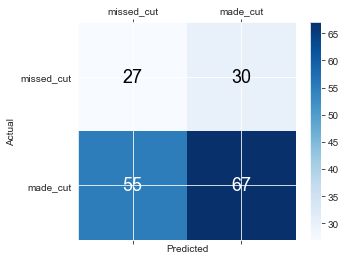

['models/noSG/base_model.pkl']

In [367]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {
    'strategy' : [
        'stratified', 
        'most_frequent',
        'prior',
        'uniform',
        'constant'
    ]
}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

### Logistic Regression

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.2s finished


------------------------------------------------------
Logistic Regression Model Best Params:
------------------------------------------------------
 C : 100000.0
 penalty : l1
 solver : liblinear
------------------------------------------------------
Logistic Regression Model F1 Scores:
------------------------------------------------------
 train:  63.28%
 test:  66.97%
------------------------------------------------------
Logistic Regression Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.41      0.60      0.49        57
    made_cut       0.76      0.60      0.67       122

    accuracy                           0.60       179
   macro avg       0.59      0.60      0.58       179
weighted avg       0.65      0.60      0.61       179

------------------------------------------------------


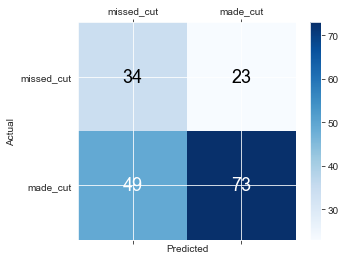

['models/noSG/log_model.pkl']

In [368]:
# Instantiate classifier and define model
classifier = LogisticRegression(random_state=SEED)
model_name = 'Logistic Regression Model'

# Create param grid for GridSearch
param_grid = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : np.logspace(-10, 10, 5),
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

### KNearest Neighbors (KNN)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


------------------------------------------------------
KNN Model Best Params:
------------------------------------------------------
 n_neighbors : 9
------------------------------------------------------
KNN Model F1 Scores:
------------------------------------------------------
 train:  68.89%
 test:  57.71%
------------------------------------------------------
KNN Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.36      0.63      0.46        57
    made_cut       0.73      0.48      0.58       122

    accuracy                           0.53       179
   macro avg       0.55      0.55      0.52       179
weighted avg       0.62      0.53      0.54       179

------------------------------------------------------


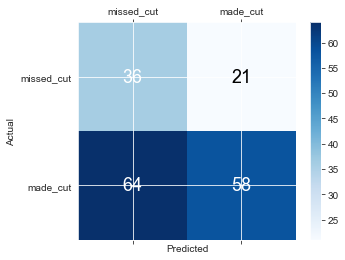

['models/noSG/knn_model.pkl']

In [369]:
# Instantiate classifier and define model
classifier = KNeighborsClassifier()
model_name = 'KNN Model'

k = int(round(np.log(X_train.shape[0]), 0))

# Create param grid for GridSearch
param_grid = {'n_neighbors' : range(k,k+20,2)}

# Instantiate GridSearch
knn_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
knn_clf.fit(X_train, y_train)
y_hat_pred = knn_clf.predict(X_train)
y_pred = knn_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = knn_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/knn_model.pkl'
model = knn_clf
joblib.dump(model, filename)

### Decision Tree

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


------------------------------------------------------
Decision Tree Model Best Params:
------------------------------------------------------
 criterion : gini
 max_depth : 5
 min_samples_leaf : 5
 min_samples_split : 5
------------------------------------------------------
Decision Tree Model F1 Scores:
------------------------------------------------------
 train:  68.40%
 test:  59.62%
------------------------------------------------------
Decision Tree Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.35      0.58      0.44        57
    made_cut       0.72      0.51      0.60       122

    accuracy                           0.53       179
   macro avg       0.54      0.54      0.52       179
weighted avg       0.60      0.53      0.55       179

------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.3s finished


['models/noSG/dt_model.pkl']

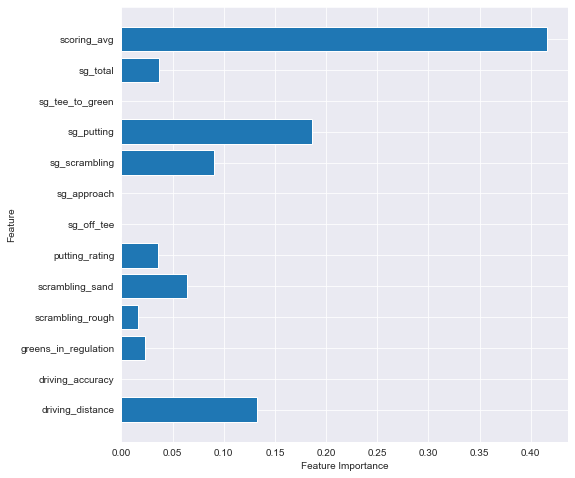

In [370]:
# Instantiate classifier and define model
classifier = DecisionTreeClassifier(random_state=SEED)
model_name = 'Decision Tree Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2, 5],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [5, 10]
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['criterion'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

### Random Forest

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   10.1s finished


------------------------------------------------------
Random Forest Model Best Params:
------------------------------------------------------
 criterion : gini
 max_depth : 5
 min_samples_leaf : 5
 min_samples_split : 5
 n_estimators : 50
------------------------------------------------------
Random Forest Model Precision Scores:
------------------------------------------------------
 train:  78.59%
 test:  74.16%
------------------------------------------------------
Random Forest Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.38      0.60      0.46        57
    made_cut       0.74      0.54      0.63       122

    accuracy                           0.56       179
   macro avg       0.56      0.57      0.54       179
weighted avg       0.63      0.56      0.57       179

------------------------------------------------------


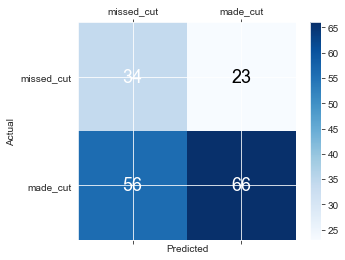

['models/noSG/rf_model.pkl']

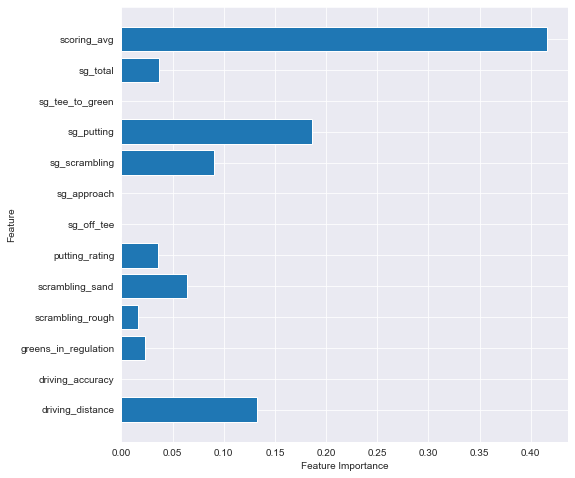

In [371]:
# Instantiate classifier and define model
classifier = RandomForestClassifier(random_state=SEED)
model_name = 'Random Forest Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [50, 100],
    'max_depth' : [2, 5],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [5, 10]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['criterion'],
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

### AdaBoost

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.2s finished


------------------------------------------------------
AdaBoost Model Best Params:
------------------------------------------------------
 learning_rate : 1
 n_estimators : 100
------------------------------------------------------
AdaBoost Model Precision Scores:
------------------------------------------------------
 train:  81.74%
 test:  71.72%
------------------------------------------------------
AdaBoost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.36      0.51      0.42        57
    made_cut       0.72      0.58      0.64       122

    accuracy                           0.56       179
   macro avg       0.54      0.55      0.53       179
weighted avg       0.60      0.56      0.57       179

------------------------------------------------------


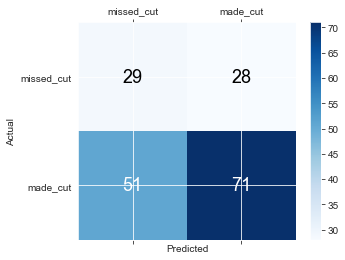

['models/noSG/ab_model.pkl']

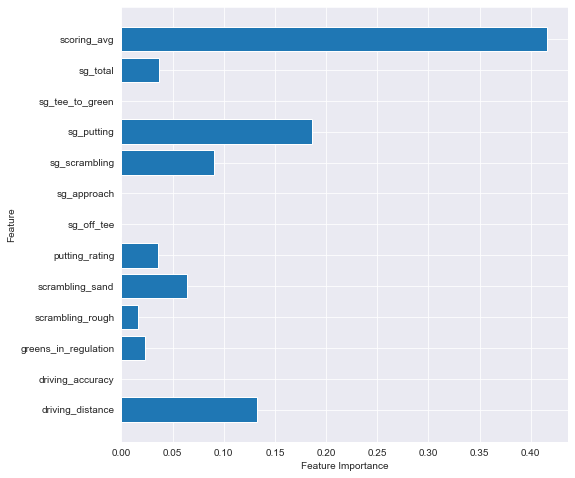

In [372]:
# Instantiate classifier and define model
classifier = AdaBoostClassifier(random_state=SEED)
model_name = 'AdaBoost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [50, 100],
    'learning_rate' : [0.1, 0.2, 0.5, 1]
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

### Gradient Boost

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.9s finished


------------------------------------------------------
Gradient Boost Model Best Params:
------------------------------------------------------
 learning_rate : 0.1
 n_estimators : 50
------------------------------------------------------
Gradient Boost Model Precision Scores:
------------------------------------------------------
 train:  84.10%
 test:  69.07%
------------------------------------------------------
Gradient Boost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.33      0.47      0.39        57
    made_cut       0.69      0.55      0.61       122

    accuracy                           0.53       179
   macro avg       0.51      0.51      0.50       179
weighted avg       0.58      0.53      0.54       179

------------------------------------------------------


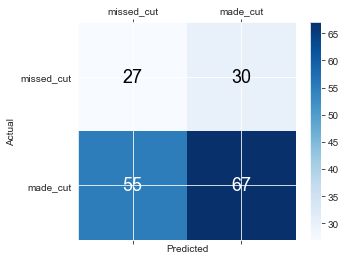

['models/noSG/gb_model.pkl']

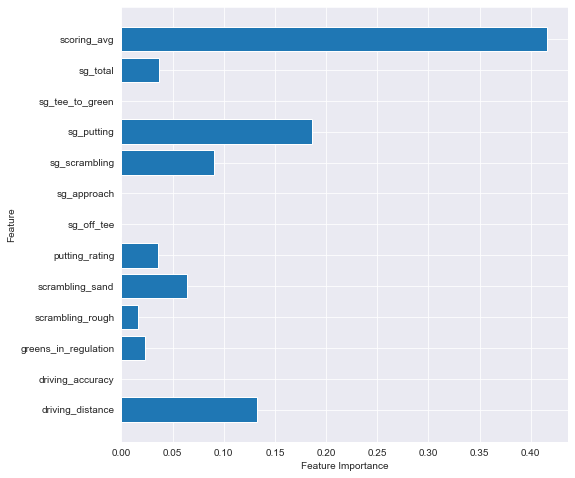

In [373]:
# Instantiate classifier and define model
classifier = GradientBoostingClassifier(random_state=SEED)
model_name = 'Gradient Boost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [50],
    'learning_rate' : [0.01, 0.1, 0.2]
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

### Support Vector Machine

In [ ]:
# # Instantiate classifier and define model
# classifier = SVC(random_state=SEED)
# model_name = 'Support Vector Machine Model'

# # Create param grid for GridSearch
# param_grid = {
#     'C' : [0.1, 1, 10],
#     'kernel' : ['linear', 'rbf', 'sigmoid'],
#     'gamma' : [0.1, 1, 10]
# }

# # Instantiate GridSearch
# svm_clf = GridSearchCV(
#     classifier,
#     param_grid,
#     cv=cv,
#     scoring=scoring,
#     verbose=2,
#     n_jobs=-1
# )

# # Fit and make predictions
# svm_clf.fit(X_train, y_train)
# y_hat_pred = svm_clf.predict(X_train)
# y_pred = svm_clf.predict(X_test)

# # Print Best Params
# print('--'*27)
# print(f'{model_name} Best Params:')
# print('--'*27)
# best_params = svm_clf.best_params_
# keys = list(best_params.keys())
# for key in keys:
#     print(f"{key} : {best_params[key]}")

# # Print Precision Score
# p_hat = metrics.precision_score(y_train, y_hat_pred)
# p = metrics.precision_score(y_test, y_pred)
# print('--'*27)
# print(f'{model_name} Precision Scores:')
# print('--'*27)
# print(f' train: {p_hat : 0.2%}')
# print(f' test: {p : 0.2%}')

# # Print classification report
# print('--'*27)
# print(f'{model_name} Classification Report')
# print('--'*27)
# print(metrics.classification_report(y_test, y_pred, target_names=target_names))
# print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(svm_clf, X_test, y_test);

# # Pickle model
# filename = 'models/gb_model.pkl'
# model = gb_clf
# joblib.dump(model, filename)

### Results Summary

In [375]:
classifiers = [dummy_clf, log_clf, knn_clf, dt_clf, rf_clf, ab_clf, gb_clf]
names = ['base', 'log_reg', 'knn', 'decTree', 'randomF', 'adaB', 'gradB']
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy_mc'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['f1_mc'] = round(metrics.f1_score(y_test, y_pred)*100,2)
    results.append(result)

results_df = pd.DataFrame(results)

print(results_df.shape)
results_df

(7, 3)


,model,accuracy_mc,f1_mc
0,base,52.51,61.19
1,log_reg,59.78,66.97
2,knn,52.51,57.71
3,decTree,53.07,59.62
4,randomF,55.87,62.56
5,adaB,55.87,64.25
6,gradB,52.51,61.19


## Top 10

### Define Key Variables

In [ ]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['outside_top_10', 'inside_top_10']
FI_labels = df.drop(['season', 'full_name', 'min', 'mean', 'made_cut', 'top_10', 'total_score'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'accuracy'

class_weight = [
    'balanced',
    {0: 0.1, 1: 0.9},
    {0: 0.3, 1: 0.7},
    {0: 0.5, 1: 0.5}
]

### Train, Test, Split

In [ ]:
X = df.drop(['season', 'full_name', 'min', 'mean', 'made_cut', 'top_10', 'total_score'], axis=1)
y = df['top_10']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# # We will use smote to handle our class imbalance
# ros = ROS(random_state=SEED)
# X_train, y_train = ros.fit_resample(X_train, y_train)

### Standarization

In [ ]:
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Base Model

In [ ]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {
    'strategy' : [
        'stratified', 
        'most_frequent',
        'prior',
        'uniform',
        'constant'
    ]
}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

### Logistic Regression

In [ ]:
# Instantiate classifier and define model
classifier = LogisticRegression(random_state=SEED)
model_name = 'Logistic Regression Model'

# Create param grid for GridSearch
param_grid = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : np.logspace(-10, 10, 5),
    'class_weight': class_weight
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

### KNearest Neighbors (KNN)

In [ ]:
# Instantiate classifier and define model
classifier = KNeighborsClassifier()
model_name = 'KNN Model'

# Create param grid for GridSearch
param_grid = {
    'n_neighbors' : range(3,80,2),
    'weights' : ['uniform', 'distance']
}

# Instantiate GridSearch
knn_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
knn_clf.fit(X_train, y_train)
y_hat_pred = knn_clf.predict(X_train)
y_pred = knn_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = knn_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/knn_model.pkl'
model = knn_clf
joblib.dump(model, filename)

### Decision Tree

In [ ]:
# Instantiate classifier and define model
classifier = DecisionTreeClassifier(random_state=SEED)
model_name = 'Decision Tree Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 10),
    'min_samples_split' : range(5, 50, 5),
    'min_samples_leaf' : range(5, 50, 5),
    'class_weight' : class_weight
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['criterion'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

### Random Forest

In [ ]:
# Instantiate classifier and define model
classifier = RandomForestClassifier(random_state=SEED)
model_name = 'Random Forest Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [100, 200],
    'max_depth' : [None, 2, 5, 10],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 5]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['criterion'],
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

### AdaBoost

In [ ]:
# Instantiate classifier and define model
classifier = AdaBoostClassifier(random_state=SEED)
model_name = 'AdaBoost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [100, 200, 500],
    'learning_rate' : [0.01, 0.1, 0.2, 0.5]
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

### Gradient Boost

In [ ]:
# Instantiate classifier and define model
classifier = GradientBoostingClassifier(random_state=SEED)
model_name = 'Gradient Boost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [100, 200, 500],
    'learning_rate' : [0.01, 0.1, 0.2, 0.5]
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

### Support Vector Machines

### Results Summary

In [ ]:
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    results.append(result)

results_df['accuracy_t10'] = 0.00
results_df['precision_t10'] = 0.00

for i in range(len(results)):
    results_df['accuracy_t10'].iloc[i] = results[i]['accuracy']
    results_df['precision_t10'].iloc[i] = results[i]['precision']

results_df

# Predicitons